In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as Ker
from PIL import Image
from tqdm import tqdm
import os 
import time 

In [2]:
#Importing all the library required for the VAE

from keras.layers import Conv2D as con_layer, Conv2DTranspose, Input, Flatten as flatn, Dense, Lambda, Reshape ,Dropout
from keras.layers import BatchNormalization as b_norm ,Activation 
from keras.models import Model ,Sequential
from keras.losses import binary_crossentropy
from keras import backend as Ker
import numpy as np
import matplotlib.pyplot as plt
import warnings as warns
warns.filterwarnings('ignore')

In [ ]:
## Google Drive was mounted for accessing the dataset which was processed ## Picked files and binary files 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Setting the parametesrs 
##GENERATE_SQUARE = 32 * 2 
##IMAGE_CHANNELS = 3
DATA_PATH = '/content/'
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
## Paths defined for cartoon dataset with 30k and 60k Dataset 
cartoon_30k = '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_30k'
cartoon_60k = '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_60k'

### path defined for Logos dataset with 30k and 60k 

logos_30k = '/content/drive/My Drive/Logo_binary_files/Logo_data_file_test_32_32'
logos_60k = '/content/drive/My Drive/Logos_dataset/logos_60k_64_64.npy'

In [ ]:
## select the dataset and slice for performing the experiment : 
in_dataset = 'Logo' ## Cartoon
in_datasize = '60'

In [ ]:
#### Code to open the saved data in colab for importing the pre-processed data

if in_dataset == 'Logo' and in_datasize == '30':
  data_path = logos_30k
elif in_dataset == 'Logo' and in_datasize == '60':
  data_path = logos_60k
elif in_dataset == 'cartoon' and in_datasize == '30':
  data_path =cartoon_30k
elif in_dataset == 'cartoon' and in_datasize == '60':
  data_path =cartoon_60k


In [ ]:
data_path

'/content/drive/My Drive/Logos_dataset/logos_60k_64_64.npy'

In [ ]:
import pickle
input_file = open(data_path,'rb')
final_dataset = pickle.load(input_file)
input_file.close()
print("Data set loaded")

Data set loaded


In [ ]:
training_data = np.load(data_path)

In [ ]:
final_dataset = training_data

In [ ]:
final_dataset.shape

(60632, 64, 64, 3)

In [ ]:
## Here the required shape for input is given since, Cartoon dataset images where of channel 4 
### Setting of hyper paramters for Each set of Slice 
input_shape = (64, 64, 3)
latent_space = 150
batch_size = 256
# Data & model configuration
img_width, img_height = 64, 64
num_channels = 3

In [ ]:
## Few changes for hyper paramters and encoder model for Logos kernel size was changes to 4 and for cartoon it was set to 3 
if in_dataset == 'Logo':
  model_kernel_size = 4
else:
  model_kernel_size = 3
en_stride =2 
e_pad ='same'
e_activation = 'relu'

In [ ]:
# Encoder model with input, Convolutional layer , Batch normalization and flattening. 
input_encod       = Input(shape=input_shape, name='inp_encod')
conv_layer1      = con_layer(filters=32, kernel_size=model_kernel_size, strides=en_stride, padding=e_pad, activation=e_activation)(input_encod) ### 8
c_norm     = b_norm()(conv_layer1)
conv_layer_2      = con_layer(filters=64, kernel_size=model_kernel_size, strides=en_stride, padding=e_pad, activation=e_activation)(c_norm)  ### 16
c2_norm      = b_norm()(conv_layer_2)
c_flatten       = flatn()(c2_norm)
c_dense      = Dense(latent_space, activation='relu')(c_flatten)
cb_norm      = b_norm()(c_dense)
mu      = Dense(latent_space, name='encoder_mu')(cb_norm)
sigma   = Dense(latent_space, name='encoder_sigma')(cb_norm)


In [ ]:

# Convert the shape for decoder operation
reshape_conv_inp = Ker.int_shape(c2_norm)

In [ ]:

#  Function for generating sample 
def generate_samples(args):
  lnt_mu, lnt_sigma = args
  inp_batch     = Ker.shape(lnt_mu)[0]
  inp_dim       = Ker.int_shape(lnt_mu)[1]
  inp_epsi       = Ker.random_normal(shape=(inp_batch, inp_dim))
  return lnt_mu + Ker.exp(lnt_sigma / 2) * inp_epsi

In [ ]:
## sampled 
z_sample  = Lambda(generate_samples, (latent_space, ), name='z_sample')([mu, sigma])


In [ ]:
## structure defined for encoder model
Variational_end = Model(input_encod, [mu, sigma, z_sample], name='Structured_encoder')
###Variational_end.summary()

In [ ]:
## Changes and selection for n-channels for cartoon and logo dataset :
if in_dataset == 'Logo':
  num_channels =3
else:
  num_channels = 4

In [ ]:
## Create decoder structure 

# Definition
input_decod   = Input(shape=(latent_space, ), name='structured_decoder_inp')
c_dense     = Dense(reshape_conv_inp[1] * reshape_conv_inp[2] * reshape_conv_inp[3], activation='relu')(input_decod)
c_norm    = b_norm()(c_dense)
c_reshape     = Reshape((reshape_conv_inp[1], reshape_conv_inp[2], reshape_conv_inp[3]))(c_norm)
c_trans    = Conv2DTranspose(filters=64,
                             kernel_size=model_kernel_size, ## kernal size 
                             strides=en_stride, ## number of strides 
                             padding=e_pad,
                             activation=e_activation)(c_reshape) ##16
c_bnorm    = b_norm()(c_trans)
c_2trans    = Conv2DTranspose(filters=32, 
                              kernel_size=model_kernel_size,
                              strides=en_stride,
                              padding=e_pad, 
                              activation=e_activation)(c_bnorm)  ## 8
c2_bnorm    = b_norm()(c_2trans)
out_put     = Conv2DTranspose(filters=num_channels, 
                              kernel_size=model_kernel_size,
                              activation='sigmoid',
                              padding=e_pad,
                              name='structured_output')(c2_bnorm)


In [ ]:

# Decoder intialization 
variational_dec = Model(input_decod, out_put, name='variational_decoder')
##variational_dec.summary()


In [ ]:

# Initiate Variational Auto-enco
Total_output = variational_dec(Variational_end(input_encod)[2])
## combine the models
Complete_var_model         = Model(input_encod, Total_output, name='Total_VAES_OPT')

### Summary of the combined model
##Complete_var_model.summary()


In [ ]:
in_sigma =  sigma 
in_mu =mu

In [ ]:
# Loss calulated for VAE model: based on KL-Loss and Binary crossentropy : Function to add both the losses 
def Calulate_loss(true, pred):
  
  loss1 = binary_crossentropy(Ker.flatten(true), Ker.flatten(pred)) * 64 * 64
  # Loss for KL
  loss_2 = 1 + in_sigma - Ker.square(in_mu) - Ker.exp(in_sigma)
  loss_2 = Ker.sum(loss_2, axis=-1)
  loss_2 *= -0.5
 
  return Ker.mean(loss1 + loss_2)


In [ ]:
# COmpile the Variational model
Complete_var_model.compile(optimizer='adam', loss=Calulate_loss)
                  ###binary_crossentropy) ,"mse"
            ###kl_reconstruction_loss)


In [ ]:
if in_dataset == 'Logo':
  Train_dataset = final_dataset
else:
  Train_dataset = final_dataset
  

In [ ]:
Train_dataset.shape

(60632, 64, 64, 3)

In [ ]:
### Fitting the model with hyper parameters : As per the Data slices for both the Datasets 
Complete_var_model.fit(Train_dataset, Train_dataset, epochs =150, batch_size = 128)


In [ ]:
#### Code to open the saved data in colab for importing the pre-processed data

cartoon_test_set ='/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_10k_test'
## For cartoon images : '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_30k'
cartoon_10k_test = open(cartoon_test_set,'rb')
final_dataset_cartoon__test = pickle.load(cartoon_10k_test)
cartoon_10k_test.close()

In [ ]:
predicted_images = Complete_var_model.predict(Train_dataset)

In [ ]:
num_sample = 10 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

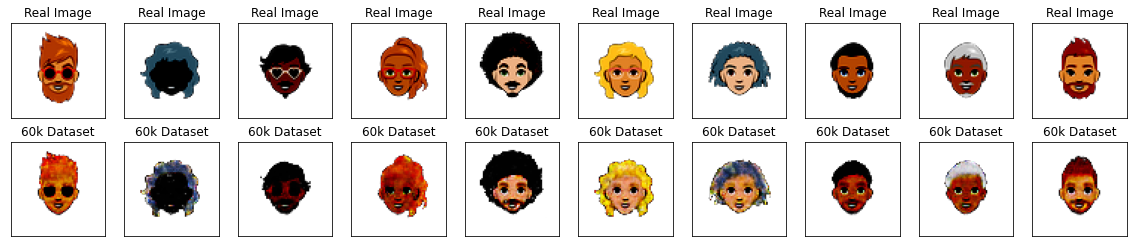

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("Real Image")
    plt.imshow(Train_dataset[i].reshape(64, 64,4))
     
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title("60k Dataset")
    plt.imshow(predicted_images[i].reshape(64, 64,4))
     
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

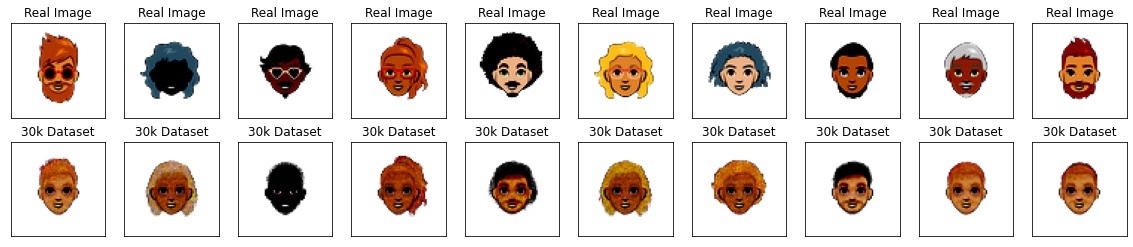

In [ ]:
no_samples = 10 
plt.figure(figsize=(20, 4))
for x in range(no_samples):
    ix = plt.subplot(2, no_samples, x + 1)
    ix.set_title("Real Image")
    plt.imshow(Train_dataset[x].reshape(64, 64,4))
    ix = plt.subplot(2, no_samples, x + 1 + no_samples)
    ix.set_title("30k Dataset")
    plt.imshow(predicted_images[x].reshape(64, 64,4))
     

In [ ]:
## Define path for test dataset :

test_data_cartoon_30k = '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_30k'
test_data_cartoon_10k = '/content/drive/My Drive/Cartoon_binary_files/cartoon_data_file_10k_test'
test_data_logos_30k = '/content/drive/My Drive/Logo_binary_files/Logo_data_30_file_test_64_64'
test_data_logo_60k = '/content/drive/My Drive/Logo_binary_files/Logo_data_60k_file_test_64_64'

In [ ]:
#### Code to open the saved data in colab for importing the pre-processed data
import pickle
if in_dataset == 'Logo':
  test_file_path = test_data_logos_30k
else:
  test_file_path = test_data_cartoon_30k
  

In [ ]:

Test_data_logos = open(test_file_path,'rb')
final_dataset_logo_test = pickle.load(Test_data_logos)
Test_data_logos.close()

In [ ]:
predicted_images = vae_model.predict(final_dataset_60k)

In [ ]:
Predict_images = vae_model.predict(Train_dataset)

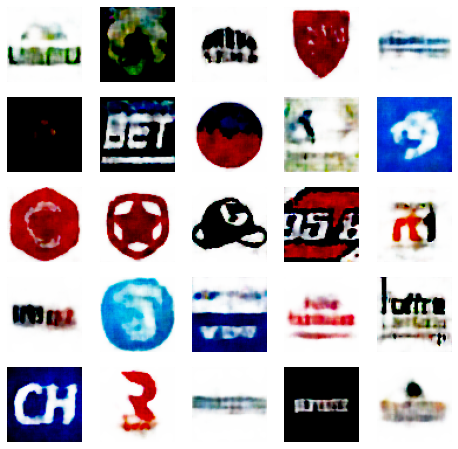

In [ ]:
# plot  images from the training dataset
plt.figure(figsize=(8,8))
for i in range(25):
     
     plt.subplot(5, 5, 1 + i)
     
     plt.axis('off')
 # plot raw pixel data
     
     plt.imshow(Predict_images[i])

plt.show()

In [ ]:
### Code to display images generated using 60k logos dataset 

In [ ]:
predicted_images = Complete_var_model.predict(Train_dataset)

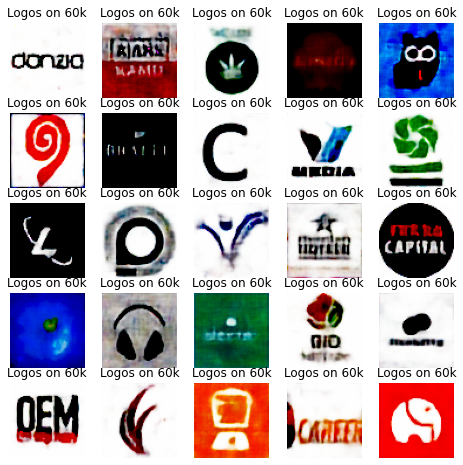

In [ ]:
# plot  images from the training dataset
plt.figure(figsize=(8,8))
for i in range(25):
     
     plt.subplot(5, 5, 1 + i)
     
     plt.axis('off')
 # plot raw pixel data
     plt.title("Logos on 60k")
     plt.imshow(predicted_images[i])

plt.show()

In [ ]:
!jupyter nbconvert --to html VAE_Images_generation_code.ipynb

[NbConvertApp] Converting notebook VAE_Images_generation_code.ipynb to html
[NbConvertApp] Writing 1162338 bytes to VAE_Images_generation_code.html
